11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
235/235 - 5s - 19ms/step - loss: 0.2773 - val_loss: 0.1921
Epoch 2/20
235/235 - 2s - 9ms/step - loss: 0.1723 - val_loss: 0.1538
Epoch 3/20
235/235 - 1s - 3ms/step - loss: 0.1442 - val_loss: 0.1336
Epoch 4/20
235/235 - 1s - 6ms/step - loss: 0.1287 - val_loss: 0.1216
Epoch 5/20
235/235 - 1s - 3ms/step - loss: 0.1184 - val_loss: 0.1131
Epoch 6/20
235/235 - 1s - 5ms/step - loss: 0.1113 - val_loss: 0.1072
Epoch 7/20
235/235 - 1s - 5ms/step - loss: 0.1062 - val_loss: 0.1030
Epoch 8/20
235/235 - 1s - 5ms/step - loss: 0.1025 - val_loss: 0.0998
Epoch 9/20
235/235 - 1s - 3ms/step - loss: 0.0998 - val_loss: 0.0974
Epoch 10/20
235/235 - 1s - 5ms/step - loss: 0.0978 - val_loss: 0.0958
Epoch 11/20
235/235 - 1s - 4ms/step - loss: 0.0964 - val_loss: 0.0947
Epoch 12/20
235/235 - 1s - 6ms/step - loss: 0.0955 - val_loss: 0.0940
Epoch 13/20
235/235 - 1s - 4ms/step - loss: 0.0949 - val_loss: 0.0933
Epoch 14/20
235/235 - 1s - 5ms/step - loss: 0.0

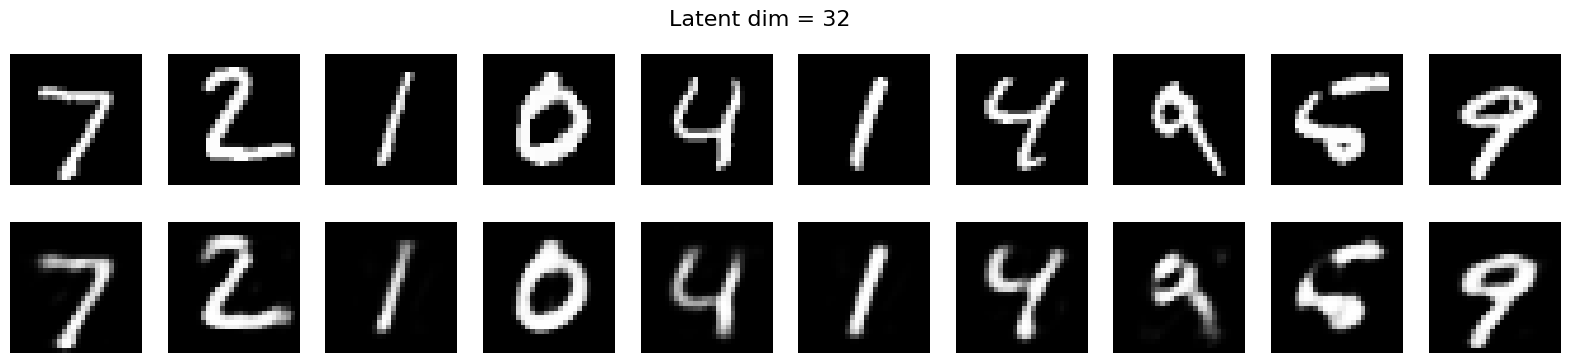

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# 1. Load & preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 784).astype("float32") / 255.0

def build_autoencoder(latent_dim):
    # 2. Define encoder
    input_img = Input(shape=(784,))
    encoded   = Dense(latent_dim, activation="relu")(input_img)
    # 2. Define decoder
    decoded   = Dense(784, activation="sigmoid")(encoded)
    # full autoencoder
    autoenc   = Model(input_img, decoded, name=f"ae_{latent_dim}")
    return autoenc

def train_and_plot(latent_dim, epochs=20, batch_size=256):
    autoenc = build_autoencoder(latent_dim)
    autoenc.compile(optimizer=Adam(), loss=BinaryCrossentropy())

    # 3. Train
    history = autoenc.fit(
        x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test, x_test),
        verbose=2
    )

    # 4. Plot original vs. reconstruction
    decoded_images = autoenc.predict(x_test[:10])

    plt.figure(figsize=(20, 4))
    for i in range(10):
        # original
        ax = plt.subplot(2, 10, i+1)
        plt.imshow(x_test[i].reshape(28,28), cmap="gray")
        plt.axis("off")

        # reconstruction
        ax = plt.subplot(2, 10, i+1+10)
        plt.imshow(decoded_images[i].reshape(28,28), cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Latent dim = {latent_dim}", fontsize=16)
    plt.show()

    return history

# Baseline with latent dimension = 32
train_and_plot(latent_dim=32)


Epoch 1/20
235/235 - 3s - 13ms/step - loss: 0.2837 - val_loss: 0.2230
Epoch 2/20
235/235 - 1s - 5ms/step - loss: 0.1967 - val_loss: 0.1788
Epoch 3/20
235/235 - 1s - 5ms/step - loss: 0.1714 - val_loss: 0.1620
Epoch 4/20
235/235 - 1s - 5ms/step - loss: 0.1577 - val_loss: 0.1508
Epoch 5/20
235/235 - 1s - 5ms/step - loss: 0.1458 - val_loss: 0.1399
Epoch 6/20
235/235 - 1s - 5ms/step - loss: 0.1388 - val_loss: 0.1352
Epoch 7/20
235/235 - 1s - 5ms/step - loss: 0.1349 - val_loss: 0.1321
Epoch 8/20
235/235 - 1s - 3ms/step - loss: 0.1320 - val_loss: 0.1298
Epoch 9/20
235/235 - 1s - 4ms/step - loss: 0.1300 - val_loss: 0.1282
Epoch 10/20
235/235 - 1s - 5ms/step - loss: 0.1287 - val_loss: 0.1272
Epoch 11/20
235/235 - 1s - 3ms/step - loss: 0.1277 - val_loss: 0.1265
Epoch 12/20
235/235 - 1s - 5ms/step - loss: 0.1271 - val_loss: 0.1260
Epoch 13/20
235/235 - 1s - 6ms/step - loss: 0.1267 - val_loss: 0.1257
Epoch 14/20
235/235 - 1s - 3ms/step - loss: 0.1264 - val_loss: 0.1254
Epoch 15/20
235/235 - 1s - 3

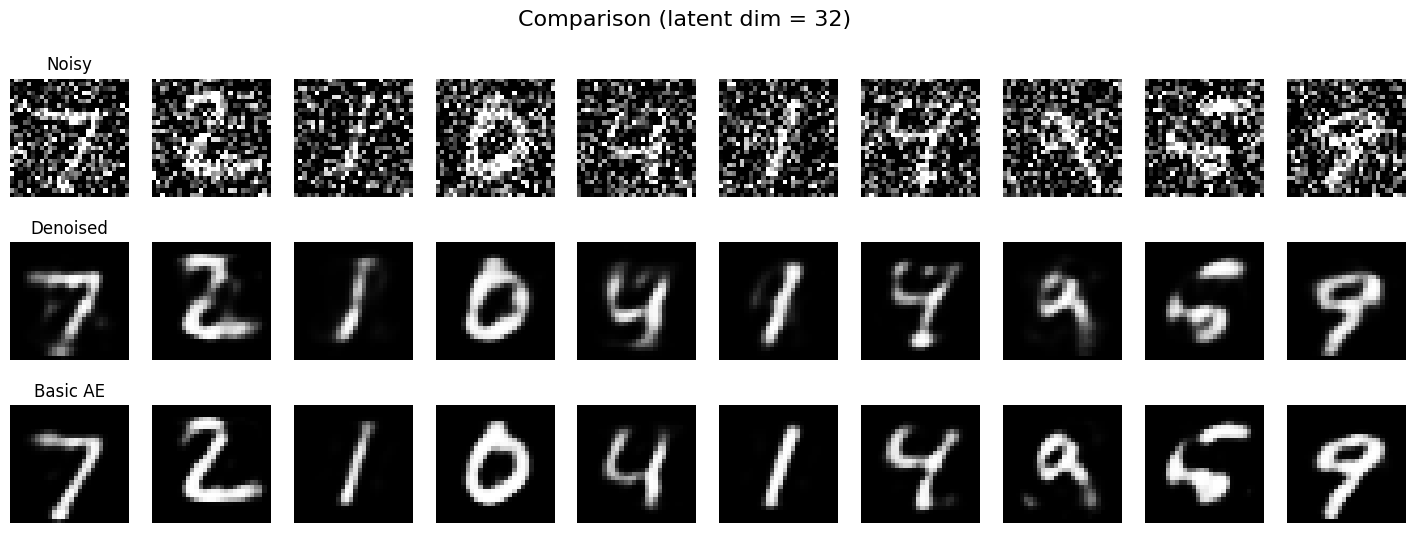

Final validation loss — basic AE: 0.09220854192972183
Final validation loss — denoising AE: 0.1245187371969223


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# 1. Load & normalize MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 784).astype("float32") / 255.0

# Function to add Gaussian noise
def add_noise(x, noise_factor=0.5):
    noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    return np.clip(noisy, 0.0, 1.0)

# Build a simple dense autoencoder (same for basic & denoising)
def build_autoencoder(latent_dim):
    input_img = Input(shape=(784,))
    encoded   = Dense(latent_dim, activation="relu")(input_img)
    decoded   = Dense(784, activation="sigmoid")(encoded)
    return Model(input_img, decoded)

# 2/3. Prepare noisy inputs & clean targets
x_train_noisy = add_noise(x_train, noise_factor=0.5)
x_test_noisy  = add_noise(x_test, noise_factor=0.5)

# 3. Instantiate, compile & train the **denoising** autoencoder
latent_dim = 32
dae = build_autoencoder(latent_dim)
dae.compile(optimizer=Adam(), loss=BinaryCrossentropy())
history_dae = dae.fit(
    x_train_noisy, x_train,        # noisy → clean
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    verbose=2
)

# For comparison: train a **basic** autoencoder on clean data
bae = build_autoencoder(latent_dim)
bae.compile(optimizer=Adam(), loss=BinaryCrossentropy())
history_bae = bae.fit(
    x_train, x_train,              # clean → clean
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=2
)

# 4. Visualize
n = 10
decoded_dae = dae.predict(x_test_noisy[:n])
decoded_bae = bae.predict(x_test[:n])

plt.figure(figsize=(18, 6))

for i in range(n):
    # noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28,28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Noisy")

    # denoising AE output
    ax = plt.subplot(3, n, n + i + 1)
    plt.imshow(decoded_dae[i].reshape(28,28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Denoised")

    # basic AE output (for reference)
    ax = plt.subplot(3, n, 2*n + i + 1)
    plt.imshow(decoded_bae[i].reshape(28,28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Basic AE")

plt.suptitle(f"Comparison (latent dim = {latent_dim})", fontsize=16)
plt.show()

# 5. Brief performance comparison
print("Final validation loss — basic AE:", history_bae.history['val_loss'][-1])
print("Final validation loss — denoising AE:", history_dae.history['val_loss'][-1])


In [4]:
import tensorflow as tf
import numpy as np
import os

# 1) Download & load the text
path = tf.keras.utils.get_file(
    "shakespeare.txt",
    "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
)
text = open(path, "r", encoding="utf-8").read()
print(f"Corpus length: {len(text)} characters")

# 2) Create character ↔ index mapping
vocab = sorted(set(text))
char2idx = {c:i for i,c in enumerate(vocab)}
idx2char = np.array(vocab)
vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

# Convert full text to int sequence
text_as_int = np.array([char2idx[c] for c in text], dtype=np.int32)

# 2) Prepare training examples / targets
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# group into sequences of length seq_length+1
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    # input: first seq_length chars, target: next char
    return chunk[:-1], chunk[1:]

dataset = sequences.map(split_input_target)

# Batch and shuffle
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (dataset
           .shuffle(BUFFER_SIZE)
           .batch(BATCH_SIZE, drop_remainder=True)
           .prefetch(tf.data.AUTOTUNE)
          )

# 3) Build the LSTM model
embedding_dim = 256
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    inputs = tf.keras.Input(shape=(None,), batch_size=batch_size)
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inputs)
    x = tf.keras.layers.LSTM(rnn_units,
                             return_sequences=True,
                             #stateful=True,
                             recurrent_initializer='glorot_uniform')(x)
    outputs = tf.keras.layers.Dense(vocab_size)(x)
    return tf.keras.Model(inputs, outputs)

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE)
model.summary()

# Compile
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

# 4) Train the model
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS)

# To generate, rebuild the model with batch_size=1 and load the weights
gen_model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
gen_model.set_weights(model.get_weights())

# 4) Text generation with temperature
def generate_text(model, start_string, num_generate=500, temperature=1.0):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)   # shape (1, len(start_string))
    text_generated = []

    #model.reset_states()
    for _ in range(num_generate):
        # predict next-char logits
        logits = model(input_eval)               # shape (1, seq_len, vocab)
        logits = logits[:, -1, :]                # take last time step: (1, vocab)

        # apply temperature
        logits = logits / temperature

        # sample from the distribution
        probs = tf.nn.softmax(logits)
        predicted_id = tf.random.categorical(tf.math.log(probs), num_samples=1)[0,0].numpy()

        # append and feed back
        text_generated.append(idx2char[predicted_id])
        input_eval = tf.expand_dims([predicted_id], 0)

    return start_string + "".join(text_generated)

print(generate_text(gen_model, start_string="ROMEO: ", num_generate=300, temperature=0.8))


Corpus length: 1115394 characters
Vocab size: 65


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (64, None)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (64, None, 256)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (64, None, 1024)       │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (64, None, 65)         │        66,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,330,241 (20.33 MB)

 Trainable params: 5,330,241 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 2.8908
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 1.8522
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - loss: 1.5867
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 1.4574
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 1.3728
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 1.3121
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - loss: 1.2620
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 1.2213
Epoch 9/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 1.1790
Epoch 10/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 1.1347
Epoch 11/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - loss: 1.0920
Epoch 12/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - loss: 1.0503
Epoch 13/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 1.0034
Epoch 14/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - loss: 0.9559
Epoch 15/20
172/172 ━━━━━━━━━

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

# 1. Load IMDB dataset (keep top 10 000 words)
VOCAB_SIZE = 10000
MAX_LEN    = 200  # max words per review

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

# 2. Tokenization is already done; just pad/truncate
x_train = pad_sequences(x_train, maxlen=MAX_LEN, padding='post', truncating='post')
x_test  = pad_sequences(x_test,  maxlen=MAX_LEN, padding='post', truncating='post')

# 3. Build LSTM classifier
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# Train
EPOCHS     = 5
BATCH_SIZE = 64

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=2
)

# 4. Predict on test set
y_pred_prob = model.predict(x_test, batch_size= BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion matrix & classification report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

report = classification_report(y_test, y_pred, target_names=['neg','pos'])
print("\nClassification Report:\n", report)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 - 7s - 22ms/step - accuracy: 0.5320 - loss: 0.6895 - val_accuracy: 0.5512 - val_loss: 0.6799
Epoch 2/5
313/313 - 9s - 27ms/step - accuracy: 0.5932 - loss: 0.6688 - val_accuracy: 0.6034 - val_loss: 0.6335
Epoch 3/5
313/313 - 3s - 11ms/step - accuracy: 0.6345 - loss: 0.6149 - val_accuracy: 0.5700 - val_loss: 0.6917
Epoch 4/5
313/313 - 5s - 17ms/step - accuracy: 0.7477 - loss: 0.5429 - val_accuracy: 0.8056 - val_loss: 0.5478
Epoch 5/5
313/313 - 5s - 16ms/step - accuracy: 0.8364 - loss: 0.4194 - val_accuracy: 0.8224 - val_loss: 0.4357
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Confusion Matrix:
 [[10126  2374]
 [ 2451 10049]]

Classification Report:
               precision    recall  f1-score   support

         neg       0.81      0.81      0.81     12500
         pos       0.81      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

